In [1]:
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv3D, ZeroPadding3D
from keras.layers.pooling import MaxPooling3D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.data_utils import Sequence
from keras.layers.advanced_activations import PReLU

Using CNTK backend


In [ ]:
import numpy as np
from glob import glob
import pandas as pd
import os
import math

luna_path = "../inputs/CSVFILES/"
luna_subset_path = "../inputs/subset*/"

mhd_file_list = glob(luna_subset_path + "*.mhd")
resampled_file_list = glob("../preprocess/*.npz")

### Load annotations

In [19]:
def load_annotations(csv_file):
    def get_filename(case):
        global mhd_file_list
        for f in mhd_file_list:
            if case in f:
                return(f)

    df_node = pd.read_csv(csv_file)
    df_node["file"] = df_node["seriesuid"].apply(get_filename)
    df_node = df_node.dropna()

    return df_node

df_node = load_annotations(luna_path + "annotations.csv")

df_node.head()

,seriesuid,coordX,coordY,coordZ,diameter_mm,file
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471,../inputs/subset8/1.3.6.1.4.1.14519.5.2.1.6279...
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.783651,-211.925149,-227.121250,4.224708,../inputs/subset8/1.3.6.1.4.1.14519.5.2.1.6279...
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,69.639017,-140.944586,876.374496,5.786348,../inputs/subset5/1.3.6.1.4.1.14519.5.2.1.6279...
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,-24.013824,192.102405,-391.081276,8.143262,../inputs/subset2/1.3.6.1.4.1.14519.5.2.1.6279...
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,2.441547,172.464881,-405.493732,18.545150,../inputs/subset2/1.3.6.1.4.1.14519.5.2.1.6279...


### Data generation

- Create 48x48x48 3D cube
- Randomly choose locations for negative samples

In [ ]:
def get_seriesuid(filepath):
    basename = os.path.basename(filepath)
    
    return basename[:-8]

def get_mhd_file(seriesuid):
    return get_filename(seriesuid)

def switch_xz(arr):
    return np.array([arr[2], arr[1], arr[0]])

def get_nodule_index(nodule_info, new_spacing, origin_zyx):
    nodule_coordinates = np.array(nodule_info[1:4]).astype(np.float32) # x,y,z

    nodule_index = np.rint((switch_xz(nodule_coordinates) - origin_zyx) / new_spacing).astype(np.int16)  # z,y,x
    
    return nodule_index

def get_random_index(shape, margin, cube_size, nodule_index_list):
    while True:
        random_index = [np.random.randint(margin, s - margin) for s in shape]

        if nodule_index_list is None or len(nodule_index_list) == 0:
            return random_index

        dist = min([np.linalg.norm(nodule_index - random_index) for nodule_index in nodule_index_list])

        if dist > math.sqrt(cube_size * cube_size * 2):
            return random_index
        else:
            # print("too close to nodule {}, nodule_list={}".format(random_index, nodule_index_list))
            continue
            
def get_range(x, minx, maxx, dim):
    hdim = dim // 2

    if x - hdim <= minx:
        xs = minx
        xe = xs + dim
    elif x + hdim >= maxx:
        xe = maxx
        xs = xe - dim
    else:
        xs = x - hdim
        xe = xs + dim
    
    return xs, xe

def get_3D_cube(img_array, x, y, z, dim):
    xr = get_range(x, 0, img_array.shape[2], dim)
    yr = get_range(y, 0, img_array.shape[1], dim)
    zr = get_range(z, 0, img_array.shape[0], dim)

    return img_array[zr[0]:zr[1], yr[0]:yr[1], xr[0]:xr[1]]

def get_feature_label_pairs(npz_file, count=2, cube_size=48, random_center=True, positive_portion=0.5):
    npz_dict = np.load(npz_file)
    resampled_img = npz_dict['resampled_img'].astype(np.float16) # zyx
    origin_zyx = npz_dict['origin_zyx']
    new_spacing = npz_dict['new_spacing'] #zyx
    seriesuid = get_seriesuid(npz_file)
    mini_df_node = df_node[df_node['seriesuid'] == seriesuid]

    features_list = []
    labels_list = []

    if len(mini_df_node) > 0:
        nodule_index_list = [get_nodule_index(nodule_info, new_spacing, origin_zyx) for nodule_info in mini_df_node.values] #zyx
    else:
        nodule_index_list = []
        positive_portion = 0.0

    pos_count = math.ceil(count * positive_portion)
    neg_count = count - pos_count

    # positive
    if len(mini_df_node) > 0:
        for i in range(pos_count):
            nodule_index = nodule_index_list[np.random.randint(len(nodule_index_list))]
            xi, yi, zi = nodule_index[2], nodule_index[1], nodule_index[0]

            # Randomize center
            if random_center:
                randi = np.random.randint(-5, +5, 3)
                xi += randi[0]
                yi += randi[1]
                zi += randi[2]

            nodule_cube = get_3D_cube(resampled_img, xi, yi, zi, cube_size)

            features_list.append(np.reshape(nodule_cube, [cube_size, cube_size, cube_size, 1]))
            labels_list.append(1)

    # negative
    for i in range(neg_count):
        random_index = get_random_index(resampled_img.shape, 0, cube_size, nodule_index_list)

        random_cube = get_3D_cube(resampled_img, random_index[2], random_index[1], random_index[0], cube_size)

        features_list.append(np.reshape(random_cube, [cube_size, cube_size, cube_size, 1]))
        labels_list.append(0)

    return features_list, labels_list

### Inspect samples

In [45]:
npz_file = resampled_file_list[6]
seriesuid = get_seriesuid(npz_file)
df_node[df_node['seriesuid'] == seriesuid]

,seriesuid,coordX,coordY,coordZ,diameter_mm,file
1027,1.3.6.1.4.1.14519.5.2.1.6279.6001.558286136379...,-77.771604,-11.389945,-58.035362,16.721463,../inputs/subset9/1.3.6.1.4.1.14519.5.2.1.6279...


In [46]:
cube_list, label_list = get_feature_label_pairs(npz_file, count=8)

print(label_list)

[1, 1, 1, 1, 0, 0, 0, 0]


#### Plot a positive sample

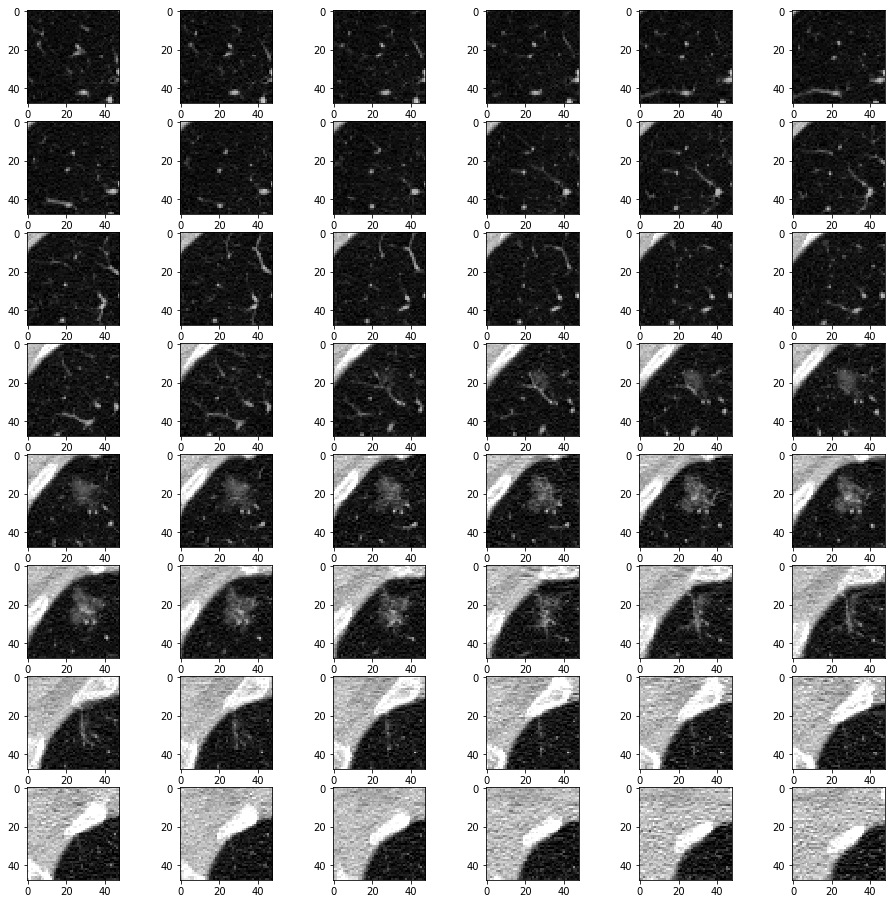

In [48]:
cube = cube_list[0]

plt.figure(figsize=(16, 16))
for i in range(0, 48):
    plt.subplot(8, 6, i + 1)
    plt.imshow(np.reshape(cube[i], (48, 48)).astype(np.float32), cmap=plt.cm.gray, vmax=1, vmin=0)

### Data Sequence

For parallel mini-batch preparation

In [ ]:
class DataSequence(Sequence):
    def __init__(self, file_list, cube_size, batch_size):
        self.file_list = file_list
        self.cube_size = cube_size
        self.batch_size = batch_size

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        npz_file = self.file_list[idx]

        fl, ll = get_feature_label_pairs(npz_file, count=self.batch_size, cube_size=self.cube_size, random_center=True)

        # import collections
        # print(idx, collections.Counter(ll))

        return np.asarray(fl), np.asarray(ll)

### Define CNN

In [21]:
def add_conv_block(model, filter, kernel=(3, 3, 3)):
    model.add(Conv3D(filter, kernel, activation='linear', padding='valid', strides=(1, 1, 1)))
    model.add(PReLU(shared_axes=[1, 2, 3]))
    model.add(BatchNormalization()) 

def get_model(input_dim=48):
    model = Sequential()
    # 1st layer group
    model.add(Conv3D(64, (3, 3, 3), activation='linear', padding='valid', strides=(1, 1, 1), input_shape=(input_dim, input_dim, input_dim, 1)))
    model.add(PReLU(shared_axes=[1, 2, 3]))
    model.add(BatchNormalization()) 

    add_conv_block(model, 64)
    model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='valid'))

    # 2nd layer group
    add_conv_block(model, 128)
    add_conv_block(model, 128)
    model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='valid'))

    # 3rd layer group
    add_conv_block(model, 256)
    add_conv_block(model, 256)

    # 4th layer group
    add_conv_block(model, 512)
    add_conv_block(model, 512)

    model.add(Flatten())

    # FC layers group
    model.add(Dense(512, activation='linear'))
    model.add(PReLU(shared_axes=[1]))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=SGD(lr=0.001, momentum=0.9, decay=1e-6, nesterov=True), metrics=['accuracy'])

    return model

In [22]:
model = get_model(input_dim)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_33 (Conv3D)           (None, 46, 46, 46, 64)    1792      
_________________________________________________________________
p_re_lu_37 (PReLU)           (None, 46, 46, 46, 64)    64        
_________________________________________________________________
batch_normalization_33 (Batc (None, 46, 46, 46, 64)    256       
_________________________________________________________________
conv3d_34 (Conv3D)           (None, 44, 44, 44, 64)    110656    
_________________________________________________________________
p_re_lu_38 (PReLU)           (None, 44, 44, 44, 64)    64        
_________________________________________________________________
batch_normalization_34 (Batc (None, 44, 44, 44, 64)    256       
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 22, 22, 22, 64)    0         
__________

### Training

In [2]:
resampled_file_list = glob("../preprocess/*.npz")
n_val_files = 80
val_file_list = resampled_file_list[:n_val_files]
train_file_list = resampled_file_list[n_val_files:]

input_dim = 48
batch_size = 8

train_gen = DataSequence(train_file_list, input_dim, batch_size)
validate_gen = DataSequence(val_file_list, input_dim, batch_size)

experiment_id = get_experiment_id()

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    ModelCheckpoint(experiment_id + "-val_loss_checkpoint.hdf5", monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto', epsilon=0.0001, cooldown=0, min_lr=1e-6)
]

history = model.fit_generator(generator=train_gen, 
                              validation_data=validate_gen,
                              steps_per_epoch=len(train_file_list),
                              validation_steps=len(val_file_list) * 3,
                              verbose=1,
                              epochs=100,
                              callbacks=callbacks,
                              workers=7, # recommend: number of cpu cores
                              use_multiprocessing=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 46, 46, 46, 64)    1792      
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 46, 46, 46, 64)    64        
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 46, 64)    256       
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 44, 44, 44, 64)    110656    
_________________________________________________________________
p_re_lu_2 (PReLU)            (None, 44, 44, 44, 64)    64        
_________________________________________________________________
batch_normalization_2 (Batch (None, 44, 44, 44, 64)    256       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 22, 22, 22, 64)    0         
__________

808/808 [==============================] - 558s - loss: 0.0408 - acc: 0.9847 - val_loss: 0.0380 - val_acc: 0.9849
Epoch 14/100
808/808 [==============================] - 557s - loss: 0.0459 - acc: 0.9833 - val_loss: 0.0387 - val_acc: 0.9854
Epoch 15/100
808/808 [==============================] - 557s - loss: 0.0490 - acc: 0.9833 - val_loss: 0.0345 - val_acc: 0.9891
Epoch 16/100
808/808 [==============================] - 557s - loss: 0.0371 - acc: 0.9858 - val_loss: 0.0573 - val_acc: 0.9745
Epoch 17/100
808/808 [==============================] - 557s - loss: 0.0339 - acc: 0.9884 - val_loss: 0.0483 - val_acc: 0.9854
Epoch 18/100
808/808 [==============================] - 557s - loss: 0.0300 - acc: 0.9892 - val_loss: 0.0299 - val_acc: 0.9896
Epoch 19/100
808/808 [==============================] - 557s - loss: 0.0317 - acc: 0.9887 - val_loss: 0.0407 - val_acc: 0.9870
Epoch 20/100
808/808 [==============================] - 557s - loss: 0.0248 - acc: 0.9912 - val_loss: 0.0450 - val_acc: 0.98

### Show learning curve

In [7]:
print(history.history.keys())

dict_keys(['loss', 'lr', 'val_loss', 'val_acc', 'acc'])


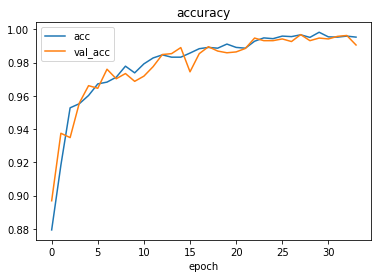

In [14]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('accuracy')
plt.xlabel('epoch')
plt.legend(['acc', 'val_acc'], loc='upper left')
plt.show()

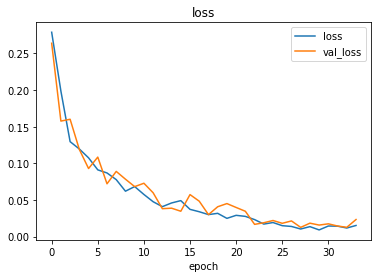

In [15]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()